# Anti-Money-Laundering test
## Table of contents

1. [Understanding the Problem](#understanding-the-problem)
2. [Preprocessing](#preprocessing)
3. [Feature Engineering](#feature-engineering)
4. [Modeling](#mode5ing)
5. [Model Evaluation](#model-evalution)
6. [Classification](#classification)
7. [Interpretation](#Interpretation)


### 1. Understanding the problem

In [1]:
# Libraries
import pandas as pd
import numpy as np
import tensorflow_data_validation as tfdv
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
# Dimension reduction 
from sklearn.decomposition import PCA
# Classifiers
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
# import warnings filter
from warnings import simplefilter
from sklearn.metrics import classification_report
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score
from collections import Counter

In [2]:
# Lets read the data with pandas, and generate first hand insights with TFDV
df = pd.read_csv('users_data.csv')
stats = tfdv.generate_statistics_from_dataframe(df)
tfdv.visualize_statistics(stats)

In [3]:
df['Label'].value_counts()
df[df['Label']==1]

UserID  TotalTransactions  TotalAmount  AverageAmount  \
1595    3281                  5  6011.002182    1202.200436   

      AverageInteractionsLast3Months  Label  
1595                            13.6      1

In [4]:
tfdv.visualize_statistics(lhs_statistics=tfdv.generate_statistics_from_dataframe(df[df['Label'] == 1]), 
                          rhs_statistics=tfdv.generate_statistics_from_dataframe(df[df['Label'] == 0]), 
                          lhs_name='launder', rhs_name='non-launder')

* The record with Label 1 is an example of a suspicious transaction. It has a large number of "TotalTransactions," a high "TotalAmount," and values for "AverageAmount" and "AverageInteractionsLast3Months" considerably higher than most other transactions. This problem can be addressed using anomaly detection, standard techniques are not optimized for detecting anomalies in such a close environment.
* The optimal approach is to employ a classification algorithm that leverages distance metrics between individual samples and a reference distribution. In this context, the distribution is derived from the majority of non-anomaly samples. Given the substantial class imbalance, constructing an effective model presents a considerable challenge due to the limited number of anomalous transactions.
* In spite of any approach that follows, the resulting model will be extremelly vulnerable to any change in the distribution of the money launders, given the lack of information, and assuming that no joins with the other dataset and no further information could be retrieved, we rely on qualitative insights, no metrics make sense in such a scenario and no data augmentation techniques can be used.
* According to the distributions, no apparent rule-based approach will differentiate the positive sample

* Furthermore:
1. There aren't any missing values in the dataset, and is composed of numeric values mixed between integers and floats.
2. The main problem comes with the existence of only one suspicious transaction, which is linked to a UserID.
3. We have a very serious information challenge. Assuming that we can't try to add more data from the second dataset, The approach will be the following
4. Total amounts vary widely, ranging from 0 to 11,200, with an average of 
5. The average amount per transaction varies from 0.03 to 6,182.19, with an averagege 9f 
6. The population in the columns is normal
7. No standardization or normalization will be applied to the numerical values, as their information is important to identify a possible pattern

# Preprocessing

Lets see the relationships between features, identify dependencies, detect multicollinearity, and visualize these items

In [5]:
# Lets start with the correlation matrix, always a good choice 
correlation_matrix = df.corr()

<Axes: >

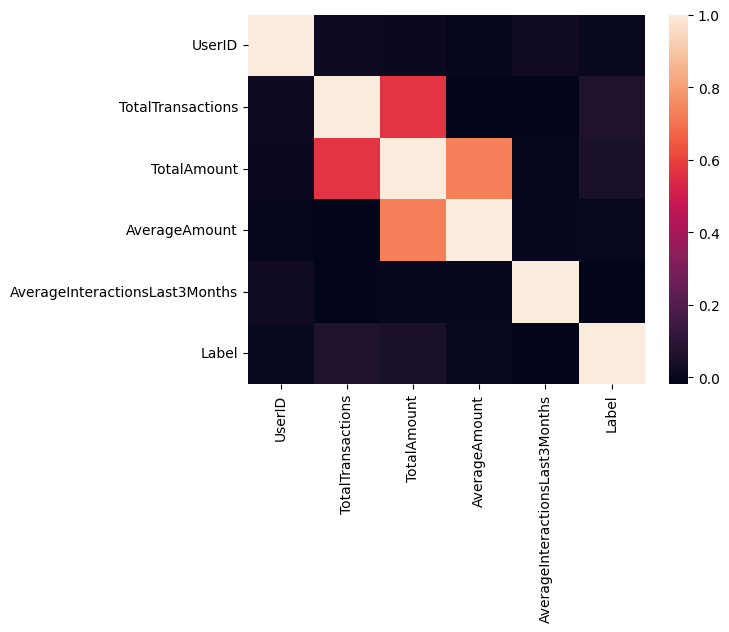

In [6]:
sns.heatmap(correlation_matrix)

There is a strong positive correlation (0.727) between "TotalAmount" and "AverageAmount," indicating that as the total amount spent increases, the average amount per transaction also tends to increase.

The good news is that the label is not directly correlated with any of the variables. This avoids potential issues with data drifting, preventing the label from leaking into one or more of the variables.

To gain a better understanding of the relationships between variables, a pair scatterplot will complement the correlation matrix analysis

C:\Users\Sebastian\anaconda3\envs\testml\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


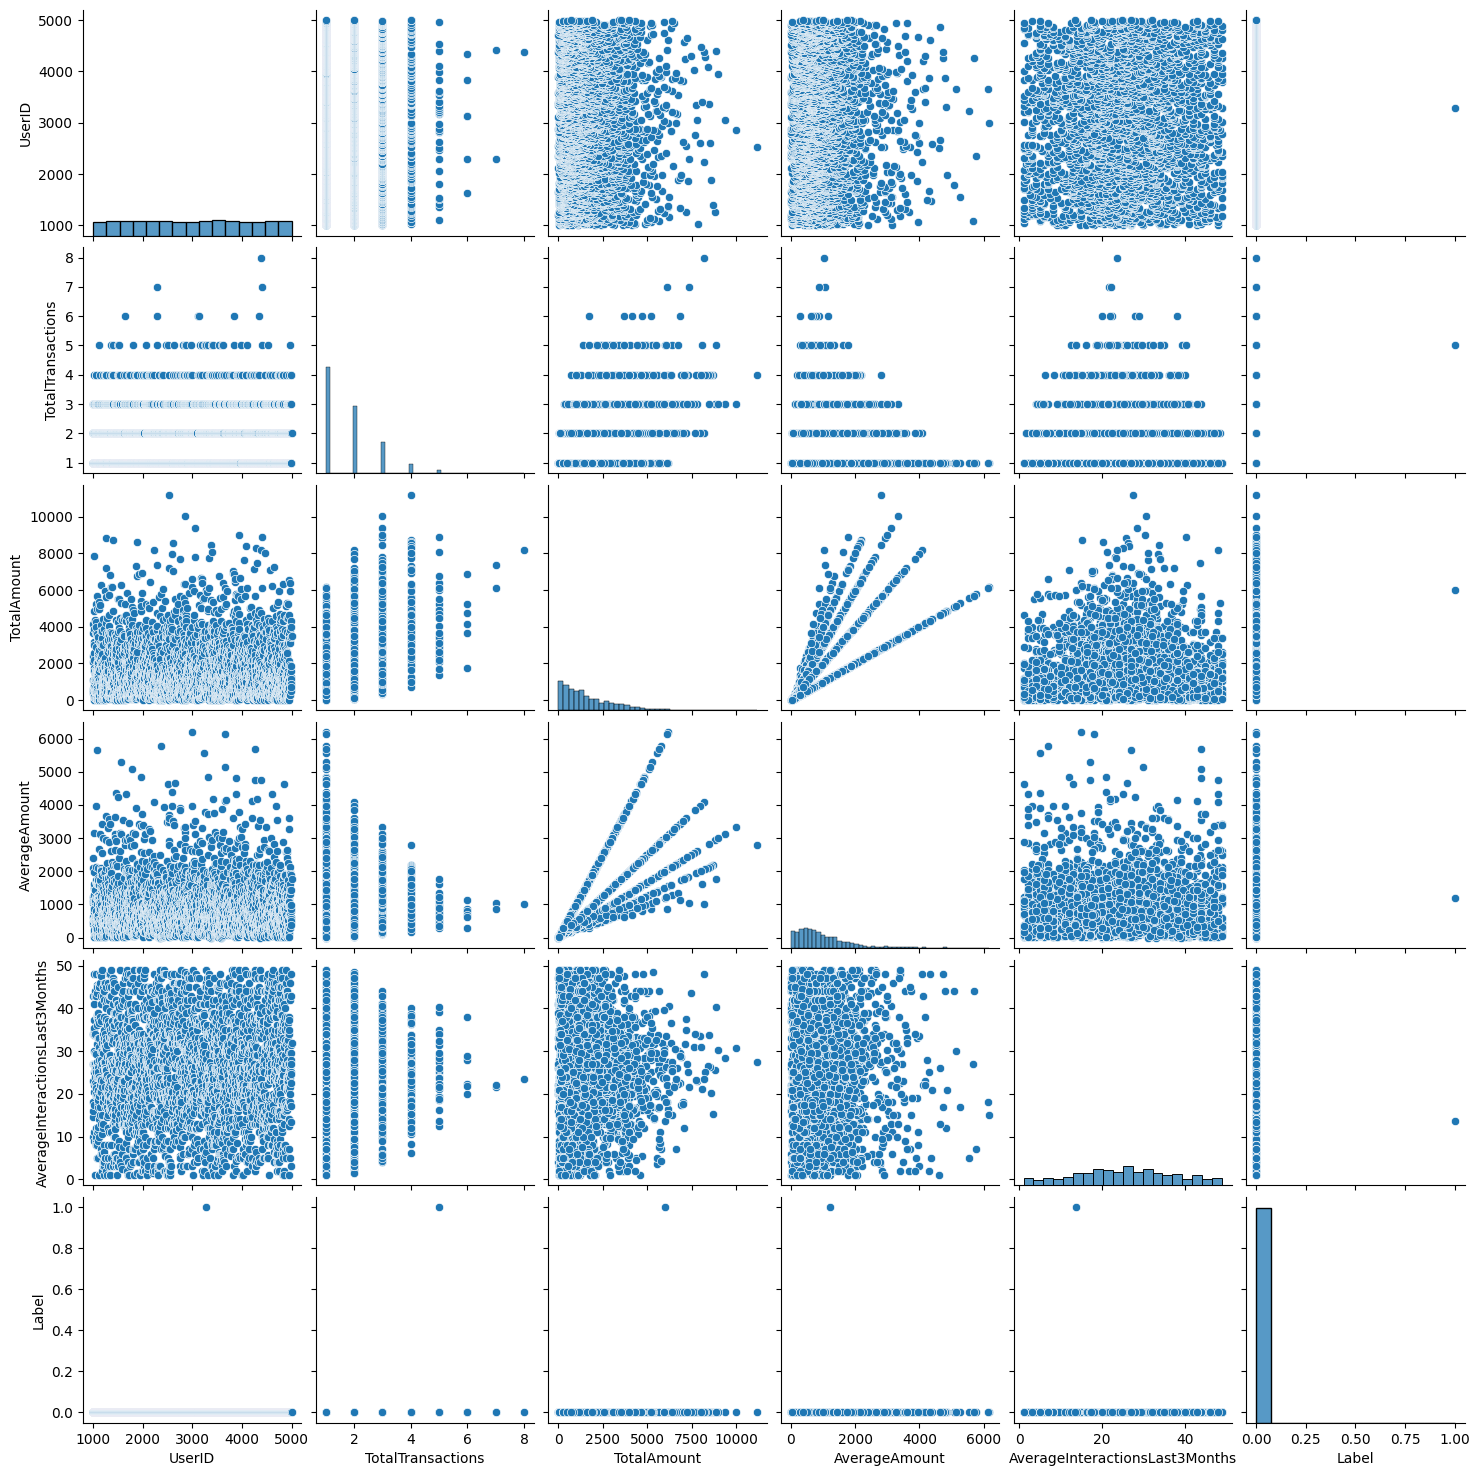

In [7]:
# Lets now use a pair scatter plot to explore more these relationships
sns.pairplot(df)

In [8]:
# Lets see if the dataset has anomalies (data-level, just strange values in our columns)
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_anomalies(tfdv.validate_statistics(statistics=stats, schema=schema))

According to the values, TotalAmount vs. TotalTransactions, AverageAmount vs. TotalTransactions, and AverageInteractionsLast3Months vs. TotalTransactions show that no potential separation in categories can be done. Therefore the possibilities for feature engineering could be limited and just a couple strategies can be tried.


### Strategy

Based on the information, we can design a strategy. <span style="color:red">Although a regression task was requested for this problem, with the current data balance, a regression model would require to select the anomaly present in the dataset, and label users that are located nearby as money launders, and then fit a model based on that assumption.</span>  for this case a mixed model strategy between clustering/classifier will be followed:

1. Create 3 feature sets, and register them in our feature store (dummy code will be provided since I don't know how data is handled in MercadoLibre's infrastructure)
2. Define classifiers: KNNClassifier, OneClassSVM, and IsolationForest. These classifiers offer diverse strategies and are popular in anomaly detection, with the exception of KNN.
4. We can't neither go for a Cross Validation Strategy or a Hyperparameter tuning process, experimental and qualitative experimentation is required.
5. Metric evaluation: the most important metrics in these cases are: 
* Precision: Precision measures the accuracy of positive predictions (i.e., how many of the predicted money laundering cases are actually money laundering). In the context of money laundering detection, high precision is important because false alarms can be costly, leading to unnecessary investigations and resource allocation.
* 
Recall (Sensitivity): Recall measures the ability of the model to capture all actual money laundering cases. It quantifies the proportion of tr e positive cases correctly identified by the model. In the context of money laundering, high recall is essential to minimize the risk of missi s suspicious transaction
* The F1-score is the harmonic mean of precision and recall. It provides a balance between these two metrics. It is particularly useful when you want to strike a balance between minimizing false alarms and ensuring high detection ra



### Feature engineering

Set 1:
Combining "TotalAmount" and "TotalTransactions" into a single feature. A "TransactionAverage" feature, which is the total amount divided by the total number of transactions. This new feature might capture the average transaction size, which could be relevant.

Set 2:
Transaction Frequency: The frequency of transactions per user over a specific time period.
Transaction Size: Feature that represents the average size of each transaction for a user.
Recent Activity: Features that capture recent activity, such as the number of interactions in the last week or month.

Set 3: Raw data


In [9]:
def return_feature_sets(df):
    """
    Process a DataFrame and return three sets of features and labels.

    This function takes a DataFrame and performs the following operations to create three sets of features and labels:

    Set 1:
    - Calculates the 'TransactionAverage' by dividing 'TotalAmount' by 'TotalTransactions'.
    - Drops columns 'TotalAmount', 'TotalTransactions', and 'UserID'.
    - Computes the correlation matrix of the resulting DataFrame.
    - Prepares features (X1) and labels (y1).

    Set 2:
    - Creates a new feature 'TransactionSize' as the average size of each transaction for a user.
    - Creates 'InteractionsLastWeek' based on 'AverageInteractionsLast3Months'.
    - Drops columns 'TotalAmount', 'TotalTransactions', and 'UserID'.
    - Prepares features (X2) and labels (y2).

    Set 3:
    - Prepares features (X3) and labels (y3) using the original DataFrame without any modifications.

    Parameters:
    ----------
    df : pandas.DataFrame
        The input DataFrame containing relevant data.

    Returns:
    -------
    tuple
        A tuple containing six elements in the following order:
        - X1 : numpy.ndarray
            Features for Set 1.
        - y1 : numpy.ndarray
            Labels for Set 1.
        - X2 : numpy.ndarray
            Features for Set 2.
        - y2 : numpy.ndarray
            Labels for Set 2.
        - X3 : numpy.ndarray
            Features for Set 3.
        - y3 : numpy.ndarray
            Labels for Set 3.

    Notes:
    ------
    - Set 1 and Set 2 involve feature engineering and dropping specific columns.
    - The correlation matrix is printed for Set 1 and Set 2 with relevant comments.
    - Set 3 uses the original DataFrame without any modifications.

    Example:
    --------
    >>> X1, y1, X2, y2, X3, y3 = return_feature_sets(my_dataframe)
    """
    # Set 1
    df_set_1 = df.copy(deep=True)
    df_set_1['TransactionAverage'] = df_set_1['TotalAmount'] / df_set_1['TotalTransactions']
    df_set_1.drop(['TotalAmount','TotalTransactions', 'UserID'], axis=1, inplace=True)
    
    print(df_set_1.corr()) # No correlations are present now in this dataset
    
    X1 = df_set_1.drop(['Label'], axis=1).values
    y1 = df_set_1['Label'].values
    
    # Save to feature store
    """
    tats = tfdv.generate_statistics_from_dataframe(df_set_1)
    stats_path = "moneylaundry-set1-v1.stats"
    # saving
    tfdv.write_stats_text(stats, stats_path)
    """
    # Set 2
    df_set_2 = df.copy(deep=True)
    
    # Create "Transaction Size" feature (average size of each transaction for a user)
    df_set_2['TransactionSize'] = df_set_2['TotalAmount'] / df_set_2['TotalTransactions']
    # Create "Recent Activity" features (number of interactions in the last week and last month)
    # Assuming AverageInteractionsLast3Months is the average interactions in 3 months
    df_set_2['InteractionsLastWeek'] = (df_set_2['AverageInteractionsLast3Months'] / 12) * 4  # Assuming 4 weeks in a month
    df_set_2.drop(['TotalAmount','TotalTransactions', 'UserID'], axis=1, inplace=True)
    
    X2 = df_set_2.drop(['Label'], axis=1).values
    y2 = df_set_2['Label'].values
    
    print(df_set_1.corr()) # Correlations are present now in this dataset because of our new variables that come from correlated ones
    # Set 3
    
    X3 = df.drop(['Label'], axis=1).values
    y3 = df['Label'].values
    return X1,y1, X2,y2,X3,y3

In [10]:
X1, y1, X2, y2, X3, y3 = return_feature_sets(df)

                                AverageAmount  AverageInteractionsLast3Months  \
AverageAmount                        1.000000                       -0.002506   
AverageInteractionsLast3Months      -0.002506                        1.000000   
Label                                0.004602                       -0.018575   
TransactionAverage                   1.000000                       -0.002506   

                                   Label  TransactionAverage  
AverageAmount                   0.004602            1.000000  
AverageInteractionsLast3Months -0.018575           -0.002506  
Label                           1.000000            0.004602  
TransactionAverage              0.004602            1.000000  
                                AverageAmount  AverageInteractionsLast3Months  \
AverageAmount                        1.000000                       -0.002506   
AverageInteractionsLast3Months      -0.002506                        1.000000   
Label                               

* No multicolinearity is present in dataset #1
* Dataset #2 has definitely got strong correlations, let's see if it gets a similar performance

# Model evaluation

A function that performs the model evaluation will be defined, in order to preserve order and reusability

In this context, the dataset is highly imbalanced, with only one positive sample (anomalous transaction) and a large number of negative samples (non-anomalous transactions). Traditional classification metrics such as precision, recall, and F1-score are not suitable for evaluating model performance due to the extreme class imbalance. Instead, let's delve into the inner workings of each classifier and why they were chosen for this problem.

Justification for the classifier choice

* K-Nearest Neighbors (KNN):
K-Nearest Neighbors is a proximity-based classification algorithm. It calculates the distances between data points (transactions in this case) and classifies them based on the majority class among their K nearest neighbors. In your scenario:

Choice Rationale: KNN is selected because it doesn't make strong assumptions about data distribution, making it suitable for anomaly detection in highly imbalanced datasets.

Operation: KNN calculates the Euclidean distance or other distance metrics between each transaction and its neighbors. For a given test transaction, if its nearest neighbors are predominantly from the negative class, it is classified as negative (non-anomalous).

* Isolation Forest:
The Isolation Forest algorithm focuses on isolating anomalies. It constructs random decision trees and isolates anomalies as shorter paths in the trees. In your scenario:

Choice Rationale: Isolation Forest is chosen because it's specifically designed for anomaly detection and is effective even with a small number of anomalies.

Operation: Isolation Forest randomly selects features and splits data points until each data point is isolated. Anomalies (anomalous transactions) are usually isolated more quickly since they require fewer splits to stand out from the majority of non-anomalous transactions.

One-Class SVM (OCSVM):
One-Class SVM is a support vector machine that identifies a region in feature space where the majority of data resides, and data points outside this region are considered anomalies. In your scenario:

Choice Rationale: OCSVM is suited for detecting anomalies in datasets where one class is significantly underrepresented.

Operation: OCSVM identifies a hyperplane that best separates the majority class (non-anomalous transactions) from the origin. Transactions that fall on the opposite side of the hyperplane are considered anomalies (anomalous). such as precision, recall, and F1-score are not suitable for evaluating model performance due to the extreme class imbalance. Instead, let's delve into the inner workings of each classifier and why they were chosen for this problem.

K-Nearest Neighbors (KNN):
:
K-Nearest Neighbors is a proximity-based classification algorithm. It calculates the distances between data points (transactions in this case) and classifies them based on the majority class among their K nearest neighbors. In your scenario:

Choice Rationale: KNN is selected because it doesn't make strong assumptions about data distribution, making it suitable for anomaly detection in highly imbalanced datasets.

OperKNN calculates the Euclidean distance or other distance metrics between each transaction and its neighbors. For a given test transaction, if its nearest neighbors are predominantly from the negative class, it is classified as negative (non-anomalous).

* Isotion Forest:
The Isolation Forest algorithm focuses on isolating anomalies. It constructs random decision trees and isolates anomalies as shorter paths in the trees. In your scenario:

Choice Rationale: Isolation Forest is chosen because it's specifically designed for anomaly detection and is effective even with a small number of anomalies.

* Opetion: Isolation Forest randomly selects features and splits data points until each data point is isolated. Anomalies (anomalous transactions) are usually isolated more quickly since they require fewer splits to stand out from the majority of non-anomalous transactions.

* Onelass SVM (OCSVM):
One-Class SVM is a support vector machine that identifies a region in feature space where the majority of data resides, and data points outside this region are considered anomalies. In your scenario:

Choice Rationale: OCSVM is suited for detecting anomalies in datasets where one class is significantly underrepresented.

Operation: OCSVM identifies a hyperplane that best separates the majority class (non-anomalous transactions) from the origin. Transactions that fall on the opposite side of the hyperplane are considered anomalies (anomalous).

### PCA visualization for feature sets

In [11]:
# Lets validate with a PCA if the outlier can be identified at plain sight
pca = PCA(n_components=3)  # Reducir a 2 componentes principales para la visualización
X_r2 = pca.fit_transform(X2)
X_r3 = pca.fit_transform(X3)

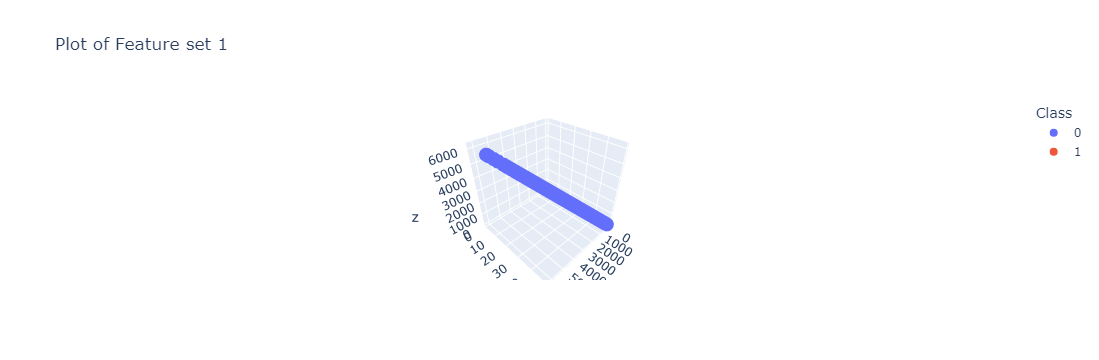

In [12]:

# Create an interactive 3D scatter plot using Plotly in Jupyter
fig = px.scatter_3d(x=X1[:, 0], y=X1[:, 1], z=X1[:, 2], color=y1.astype(str),
                     labels={'color': 'Class'}, title='Plot of Feature set 1')
fig.show()  # Specify the renderer for Jupyter

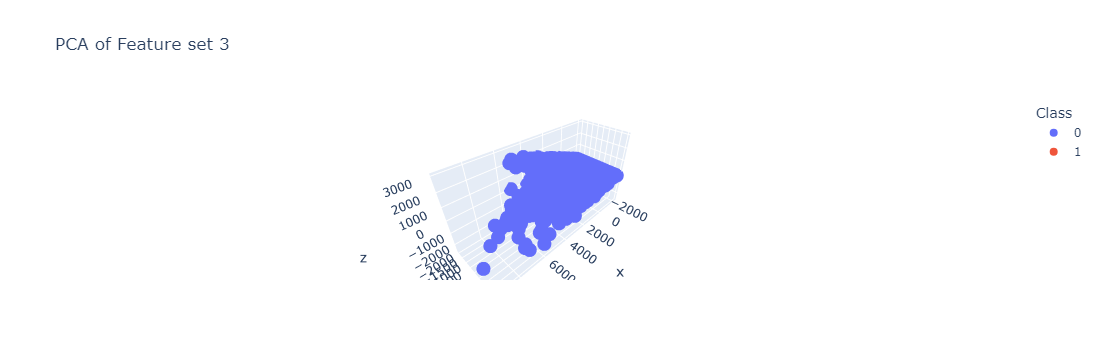

In [13]:
# Create an interactive 3D scatter plot using Plotly in Jupyter
fig = px.scatter_3d(x=X_r3[:, 0], y=X_r3[:, 1], z=X_r3[:, 2], color=y3.astype(str),
                     labels={'color': 'Class'}, title='PCA of Feature set 3')
fig.show()  # Specify the renderer for Jupyter

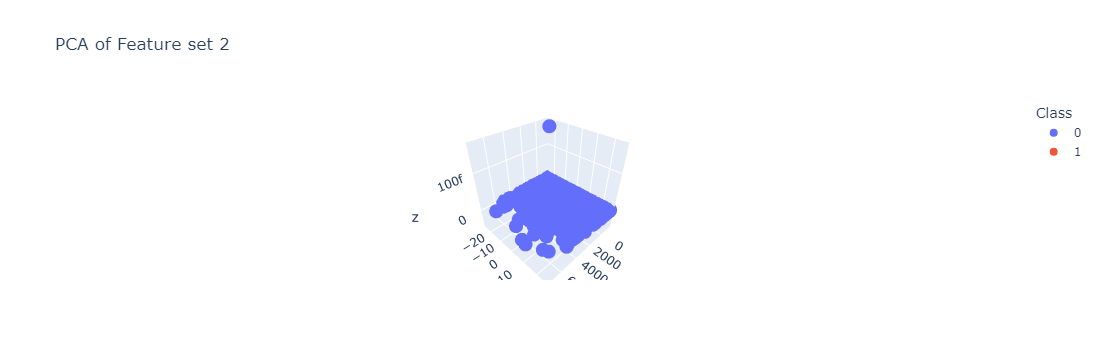

In [14]:

# Create an interactive 3D scatter plot using Plotly in Jupyter
fig = px.scatter_3d(x=X_r2[:, 0], y=X_r2[:, 1], z=X_r2[:, 2], color=y2.astype(str),
                     labels={'color': 'Class'}, title='PCA of Feature set 2')
fig.show()  # Specify the renderer for Jupyter

* It is evident that feature sets 2 and 3 have characteristics that could potentially separate the data points, therefore they are going to be priority.
* In order to correctly identify the decision boundary, we are going to define a helper function that allows us to plot points correctly
* We are going to extract the anomaly along with some data points from the dataset in order to generate a test set, the objective of this approach is to measure how capable the model is to differentiate samples including the laundry. Running this experiment multiple times will ensure randomness.



### Classification

In [15]:
# Let's reassign our sets for classification, the idea is to remove the positive sample from the dataset in order to test with it along 

anomaly_index = df[df['Label'] == 1].index[0]
y_anomaly =  df[df['Label'] == 1]['Label'].values
X_anomaly = df[df['Label'] == 1].drop(['Label'], axis=1).values

X1, y1, X2, y2, X3, y3 = return_feature_sets(df.drop(anomaly_index))

                                AverageAmount  AverageInteractionsLast3Months  \
AverageAmount                        1.000000                       -0.002421   
AverageInteractionsLast3Months      -0.002421                        1.000000   
Label                                     NaN                             NaN   
TransactionAverage                   1.000000                       -0.002421   

                                Label  TransactionAverage  
AverageAmount                     NaN            1.000000  
AverageInteractionsLast3Months    NaN           -0.002421  
Label                             NaN                 NaN  
TransactionAverage                NaN            1.000000  
                                AverageAmount  AverageInteractionsLast3Months  \
AverageAmount                        1.000000                       -0.002421   
AverageInteractionsLast3Months      -0.002421                        1.000000   
Label                                     NaN      

In [16]:
y_anomaly

array([1], dtype=int64)

In [17]:
def anomaly_detection_models(X, y, classifiers_params):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
    y_test = np.concatenate((y_test, y_anomaly), axis = 0)
    X_test = np.concatenate((X_test, X_anomaly),  axis = 0)

    
    # Initialize and train K-Nearest Neighbors (KNN) classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=classifiers_params['knn']['n_neighbors'])
    knn_classifier.fit(X_train, y_train)

    # Initialize and train One-Class SVM (OCSVM)
    ocsvm = OneClassSVM(kernel=classifiers_params['svc']['kernel'], nu=classifiers_params['svc']['nu'])
    ocsvm.fit(X_train)

    # Initialize and train Isolation Forest
    isolation_forest = IsolationForest(contamination=classifiers_params['isolation_forest']['contamination'],
                                       random_state=classifiers_params['isolation_forest']['random_state'])
    isolation_forest.fit(X_train)


    # Make predictions on the test sets
    knn_predictions = knn_classifier.predict(X_test)
    ocsvm_predictions = ocsvm.predict(X_test)
    isolation_forest_predictions = isolation_forest.predict(X_test)
    
    # Calculate accuracy and generate classification report for each classifier
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    ocsvm_accuracy = accuracy_score(y_test, ocsvm_predictions)
    isolation_forest_accuracy = accuracy_score(y_test, isolation_forest_predictions)
    
    knn_report = classification_report(y_test, knn_predictions, target_names=['Normal', 'Anomaly'],zero_division=1)
    anomaly_knn = knn_predictions[-1]
    # For the outlier detection algorithms
    y_test[-1] = -1
    y_test[:-1] = 1
    ocsvm_report = classification_report(y_test, ocsvm_predictions, target_names=['Normal', 'Anomaly'],zero_division=1)
    anomaly_ocsvm = ocsvm_predictions[-1]
    isolation_forest_report = classification_report(y_test, isolation_forest_predictions, target_names=['Normal', 'Anomaly'], zero_division=1)
    anomaly_isolation = isolation_forest_predictions[-1]
    return {'KNN Classifier': {'Model': knn_classifier,
                               'Accuracy': knn_accuracy,
                               'Classification Report': knn_report
                              },'One-Class SVM': {
                'Model': ocsvm,
                'Accuracy': ocsvm_accuracy,
                'Classification Report': ocsvm_report},
            'Isolation Forest': {
                'Model': isolation_forest,
                'Accuracy': isolation_forest_accuracy,
                'Classification Report': isolation_forest_report},
           'anomalies_pred':{'knn':anomaly_knn,
                            'ocsvm':anomaly_ocsvm,
                            'isolation_forest':anomaly_isolation}}


* The experiment will be conducted 50 times, and reports will be saved to assess how effectively the model detects anomalies without mislabeling normal samples as anomalies.
* The process will be repeated for the three feature sets.

In [18]:
def run_experiment(X, y):
    """
    Run an anomaly detection experiment using multiple models and iterations.

    Parameters:
    -----------
    X : array-like or pd.DataFrame
        Input features for the anomaly detection experiment.
    y : array-like or pd.Series
        Ground truth labels for the input data.

    Returns:
    --------
    None

    This function runs an anomaly detection experiment using various models and iterations.
    It prints classification reports for each iteration and calculates the mode of anomaly
    predictions across all iterations for each method (KNN Classifier, One-Class SVM, Isolation Forest).

    Example:
    --------
    X, y = load_data()  # Load your dataset here
    run_experiment(X, y)
    """
    # Initialize an empty list to store the results for each iteration
    all_results = []

    # Initialize empty lists to store the anomaly predictions for each iteration
    knn_predictions_list = []
    ocsvm_predictions_list = []
    isolation_forest_predictions_list = []

    # Initialize empty lists to store classification reports for each iteration
    knn_reports = []
    ocsvm_reports = []
    isolation_forest_reports = []

    # Define the number of iterations (experiments)
    num_iterations = 50

    for i in range(num_iterations):
        # Call the function and store the results
        iteration_results = anomaly_detection_models(X3, y3, classifiers_params)

        # Append the results to the list
        all_results.append(iteration_results)

    # Now, you can access the results for each iteration using a loop or by indexing the list
    for i, results in enumerate(all_results):

        # Access results for KNN Classifier
        knn_results = results['KNN Classifier']

        # Access results for One-Class SVM
        ocsvm_results = results['One-Class SVM']

        # Access results for Isolation Forest
        if_results = results['Isolation Forest']

        # Access anomaly predictions for each method
        anomalies_pred = results['anomalies_pred']

        # Append the predictions to the respective lists for each method
        knn_predictions_list.append(anomalies_pred['knn'])
        ocsvm_predictions_list.append(anomalies_pred['ocsvm'])
        isolation_forest_predictions_list.append(anomalies_pred['isolation_forest'])

        # Append the classification report
        knn_reports.append(knn_results['Classification Report'])
        ocsvm_reports.append(ocsvm_results['Classification Report'])
        isolation_forest_reports.append(if_results['Classification Report'])

    # Calculate the mode for each method's predictions across all iterations
    knn_mode = Counter(knn_predictions_list).most_common(1)[0]
    ocsvm_mode = Counter(ocsvm_predictions_list).most_common(1)[0]
    isolation_forest_mode = Counter(isolation_forest_predictions_list).most_common(1)[0]

    # Print the mode of predictions
    print("Mode of Anomaly Predictions:")
    print(f"KNN: Mode - {knn_mode[0]}, Count - {knn_mode[1]}")
    print(f"One-Class SVM: Mode - {ocsvm_mode[0]}, Count - {ocsvm_mode[1]}")
    print(f"Isolation Forest: Mode - {isolation_forest_mode[0]}, Count - {isolation_forest_mode[1]}")
    return results['KNN Classifier'], results['One-Class SVM'], results['Isolation Forest']

In [19]:
# Declare classifier parameters
classifiers_params = {
    'knn': {'n_neighbors': 5},
    'svc': {'kernel': 'rbf', 'nu': 0.3},
    'isolation_forest': {'contamination': 0.05, 'random_state': 42}
}


In [20]:
# Initialize an empty list to store the results for each iteration
all_results = []
# Initialize empty lists to store the anomaly predictions for each iteration
knn_predictions_list = []
ocsvm_predictions_list = []
isolation_forest_predictions_list = []
# Initialize empty lists to store classification reports for each iteration
knn_reports = []
ocsvm_reports = []
isolation_forest_reports = []
# Define the number of iterations (experiments)
num_iterations = 50

for i in range(num_iterations):
    # Call the function and store the results
    iteration_results = anomaly_detection_models(X3, y3, classifiers_params)
    
    # Append the results to the list
    all_results.append(iteration_results)

# Now, you can access the results for each iteration using a loop or by indexing the list
for i, results in enumerate(all_results):

    # Access results for KNN Classifier
    knn_results = results['KNN Classifier']

    # Access results for One-Class SVM
    ocsvm_results = results['One-Class SVM']

    # Access results for Isolation Forest
    if_results = results['Isolation Forest']
    # Access anomaly predictions for each method
    anomalies_pred = results['anomalies_pred']
    
    # Append the predictions to the respective lists for each method
    knn_predictions_list.append(anomalies_pred['knn'])
    ocsvm_predictions_list.append(anomalies_pred['ocsvm'])
    isolation_forest_predictions_list.append(anomalies_pred['isolation_forest'])

    # Append the classifcation report
    knn_reports.append(knn_results['Classification Report'])
    ocsvm_reports.append(ocsvm_results['Classification Report'])
    isolation_forest_reports.append(if_results['Classification Report'])
    
# Calculate the mode for each method's predictions across all iterations
knn_mode = Counter(knn_predictions_list).most_common(1)[0]
ocsvm_mode = Counter(ocsvm_predictions_list).most_common(1)[0]
isolation_forest_mode = Counter(isolation_forest_predictions_list).most_common(1)[0]

# Print the mode of predictions
print("Mode of Anomaly Predictions:")
print(f"KNN: Mode - {knn_mode[0]}, Count - {knn_mode[1]}")
print(f"One-Class SVM: Mode - {ocsvm_mode[0]}, Count - {ocsvm_mode[1]}")
print(f"Isolation Forest: Mode - {isolation_forest_mode[0]}, Count - {isolation_forest_mode[1]}")


Mode of Anomaly Predictions:
KNN: Mode - 0, Count - 50
One-Class SVM: Mode - -1, Count - 50
Isolation Forest: Mode - -1, Count - 50


In [21]:
run_experiment(X1,y1)

Mode of Anomaly Predictions:
KNN: Mode - 0, Count - 50
One-Class SVM: Mode - -1, Count - 50
Isolation Forest: Mode - -1, Count - 50


({'Model': KNeighborsClassifier(),
  'Accuracy': 0.9982238010657194,
  'Classification Report': '              precision    recall  f1-score   support\n\n      Normal       1.00      1.00      1.00       562\n     Anomaly       1.00      0.00      0.00         1\n\n    accuracy                           1.00       563\n   macro avg       1.00      0.50      0.50       563\nweighted avg       1.00      1.00      1.00       563\n'},
 {'Model': OneClassSVM(nu=0.3),
  'Accuracy': 0.0,
  'Classification Report': '              precision    recall  f1-score   support\n\n      Normal       0.01      1.00      0.01         1\n     Anomaly       1.00      0.71      0.83       562\n\n    accuracy                           0.71       563\n   macro avg       0.50      0.85      0.42       563\nweighted avg       1.00      0.71      0.83       563\n'},
 {'Model': IsolationForest(contamination=0.05, random_state=42),
  'Accuracy': 0.0,
  'Classification Report': '              precision    recall  f

In [22]:
run_experiment(X2,y2)

Mode of Anomaly Predictions:
KNN: Mode - 0, Count - 50
One-Class SVM: Mode - -1, Count - 50
Isolation Forest: Mode - -1, Count - 50


({'Model': KNeighborsClassifier(),
  'Accuracy': 0.9982238010657194,
  'Classification Report': '              precision    recall  f1-score   support\n\n      Normal       1.00      1.00      1.00       562\n     Anomaly       1.00      0.00      0.00         1\n\n    accuracy                           1.00       563\n   macro avg       1.00      0.50      0.50       563\nweighted avg       1.00      1.00      1.00       563\n'},
 {'Model': OneClassSVM(nu=0.3),
  'Accuracy': 0.0,
  'Classification Report': '              precision    recall  f1-score   support\n\n      Normal       0.01      1.00      0.01         1\n     Anomaly       1.00      0.71      0.83       562\n\n    accuracy                           0.71       563\n   macro avg       0.50      0.85      0.42       563\nweighted avg       1.00      0.71      0.83       563\n'},
 {'Model': IsolationForest(contamination=0.05, random_state=42),
  'Accuracy': 0.0,
  'Classification Report': '              precision    recall  f

In [23]:
run_experiment(X3,y3)

Mode of Anomaly Predictions:
KNN: Mode - 0, Count - 50
One-Class SVM: Mode - -1, Count - 50
Isolation Forest: Mode - -1, Count - 50


({'Model': KNeighborsClassifier(),
  'Accuracy': 0.9982238010657194,
  'Classification Report': '              precision    recall  f1-score   support\n\n      Normal       1.00      1.00      1.00       562\n     Anomaly       1.00      0.00      0.00         1\n\n    accuracy                           1.00       563\n   macro avg       1.00      0.50      0.50       563\nweighted avg       1.00      1.00      1.00       563\n'},
 {'Model': OneClassSVM(nu=0.3),
  'Accuracy': 0.0,
  'Classification Report': '              precision    recall  f1-score   support\n\n      Normal       0.01      1.00      0.01         1\n     Anomaly       1.00      0.71      0.83       562\n\n    accuracy                           0.71       563\n   macro avg       0.50      0.85      0.42       563\nweighted avg       1.00      0.71      0.83       563\n'},
 {'Model': IsolationForest(contamination=0.05, random_state=42),
  'Accuracy': 0.0,
  'Classification Report': '              precision    recall  f

# Interpretation

* The KNN Classifier performed worst than the rest, this is due to the way clusters are initialized and the way the assosiations between points are decided by the neighbors
* Both The OneClassSVM Classifier and the Isolation Forest Classifier performed well, this indicates that the decision boundaries in the SVM are apparently adequate for separating patterns such as the one present in the non outlier samples.
* The lack of data for the outlier class indicates that no algorithm either rule-based of ML-based will be able to separate samples that are not present in the given dataset.
* More features can provide more information relevant for the classification process, maybe the transactional information such as the one present in the next dataset can further help discover patterns for the anomalies, such as suspicious amounts of transactions, frequencies, dates etc.

In [24]:
# Sve to model registry e.g
"""
from joblib import dump, load
dump(ocsvm_results['Model'], 's3://bucket/path_to_model/supervised/client/version/model.joblib') 
dump(if_results['Model'], 's3://bucket/path_to_model/supervised/client/version/model.joblib') 
"""

"\nfrom joblib import dump, load\ndump(ocsvm_results['Model'], 's3://bucket/path_to_model/client/version/model.joblib') \ndump(if_results['Model'], 's3://bucket/path_to_model/client/version/model.joblib') \n"